## Predicting the Relationship Between Student Knowledge Level and Study Habits of Electrical DC Machines

#### Introduction

Our project topic is about student understanding and knowledge of a subject in relationship to the students' study habits. Students often employ many different study techniques for different subjects in hopes to gain a full understanding of the topic. Study habits include the time spent studying the subject, repitition of the subject, exam performance in the subject, as well as how the study habits of related subjects impacts the students' knowledge of the goal subject. 

For our project, our question is can we predict the knowledge level of students based off of their study habits? The dataset that we will use to answer our question is a collection of data obtained from a Ph. D. thesis ("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN"). The data includes information about students’ knowledge of Electrical DC Machines on a ranking from  very_low, low, middle, and high. The dataset also includes information about how long the students spent studying the subject, related subjects, the students’ exam performance in Electrical DC Machines, and the students' exam performance in related subjects - all were ranked on a scale of 0-1. For our project, we plan to predict the knowledge level of the users of Electrical DC Machine based on their STG (degree of study time for goal object materials), SCG (degree of repetition number of user for goal object material), STR (degree of study time of user for related objects with goal objects), LPR (exam performance of user for related objects with goal object), PEG (exam performance of user for goal objects). 

#### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(readxl)
library(tidymodels)
set.seed(7)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# reading data frame into R from the web, and cleaning and wrangling data into tidy format

student_data <- read_csv("https://raw.githubusercontent.com/maywilsdon/dsci-100-2023s1-group-20/main/data/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN%20(2).csv")|>
    select(STG:UNS) |>
    select(-SCG) |>
    mutate(UNS = as.factor(UNS))
colnames(student_data) <- c("study_time","related_subject_time", "related_exam_performance",  "exam_performance","knowledge_level")

student_data <- mutate(student_data, exam_performance_percentage = exam_performance * 100)

head(student_data)
tail(student_data)



New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


study_time,related_subject_time,related_exam_performance,exam_performance,knowledge_level,exam_performance_percentage
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.00,0.00,0.00,0.00,very_low,0
0.08,0.10,0.24,0.90,High,90
0.06,0.05,0.25,0.33,Low,33
0.10,0.15,0.65,0.30,Middle,30
0.08,0.08,0.98,0.24,Low,24
0.09,0.40,0.10,0.66,Middle,66


study_time,related_subject_time,related_exam_performance,exam_performance,knowledge_level,exam_performance_percentage
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.54,0.55,0.64,0.19,Low,19
0.61,0.69,0.92,0.58,High,58
0.78,0.71,0.19,0.60,Middle,60
0.54,0.71,0.29,0.77,High,77
0.50,0.81,0.61,0.26,Middle,26
0.66,0.76,0.87,0.74,High,74


In [3]:
# Splitting our data into training data set and testing data set

student_split <- initial_split(student_data, prop = 0.75, strata = knowledge_level)  
student_train <- training(student_split)   
student_test <- testing(student_split)

In [4]:
# Summarizing our training data into a table containing the means of the predicting variables according to 
# student knowledge_level class (High, Low, Middle, or very_low)

student_average <- student_train |>
    group_by(knowledge_level) |>
    summarize(across(study_time:exam_performance, mean)) |>
    mutate(exam_performance_percentage = exam_performance * 100)
student_average



knowledge_level,study_time,related_subject_time,related_exam_performance,exam_performance,exam_performance_percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,0.4130426,0.5195745,0.5008511,0.77446809,77.446809
Low,0.3255167,0.4488333,0.5246667,0.23588333,23.588333
Middle,0.4033846,0.5207692,0.3475385,0.53676923,53.676923
very_low,0.3156667,0.3566667,0.3600000,0.09095238,9.095238


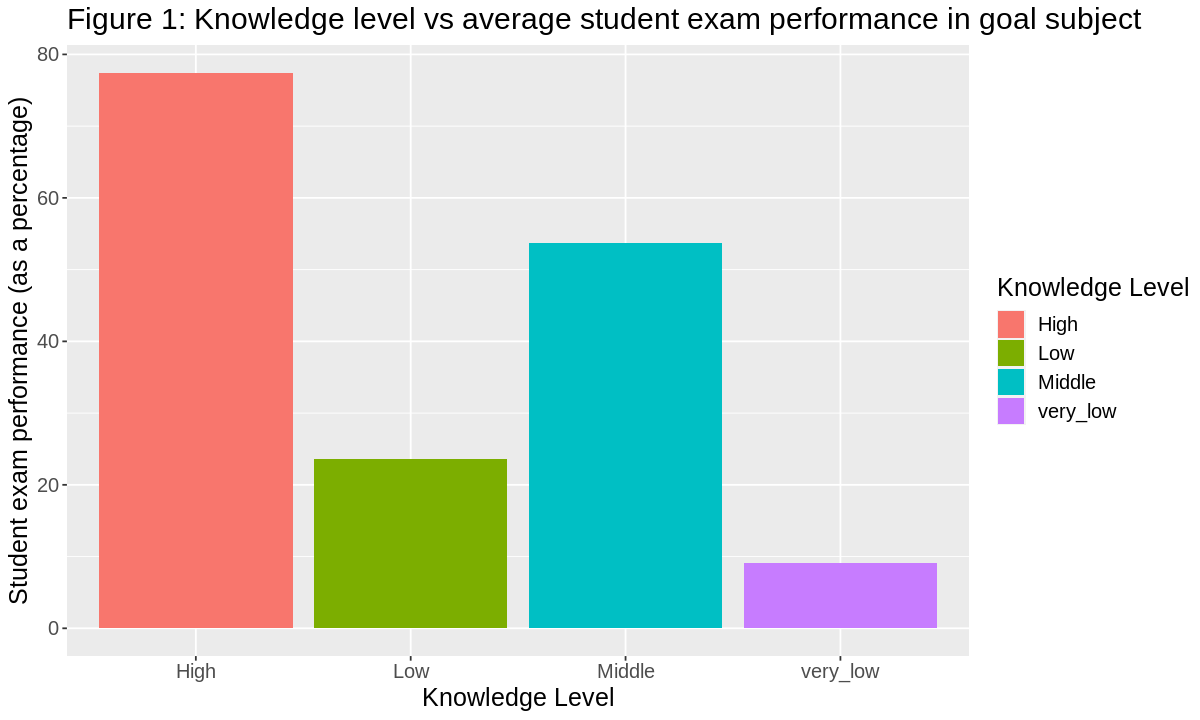

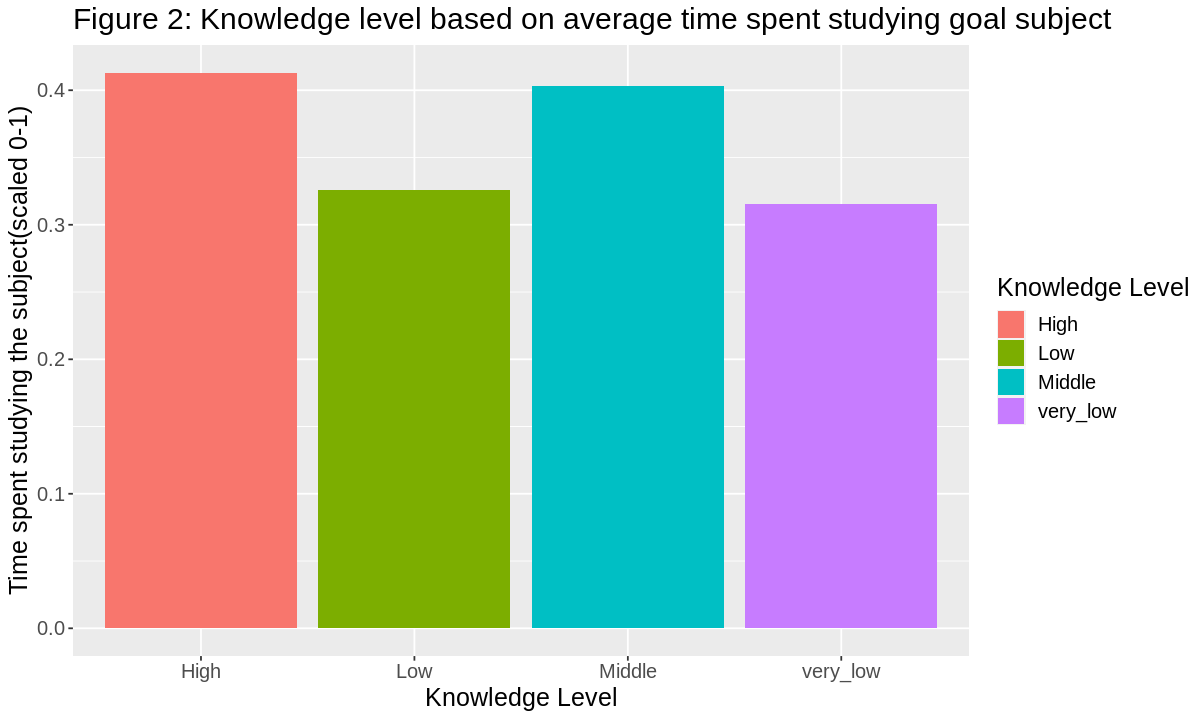

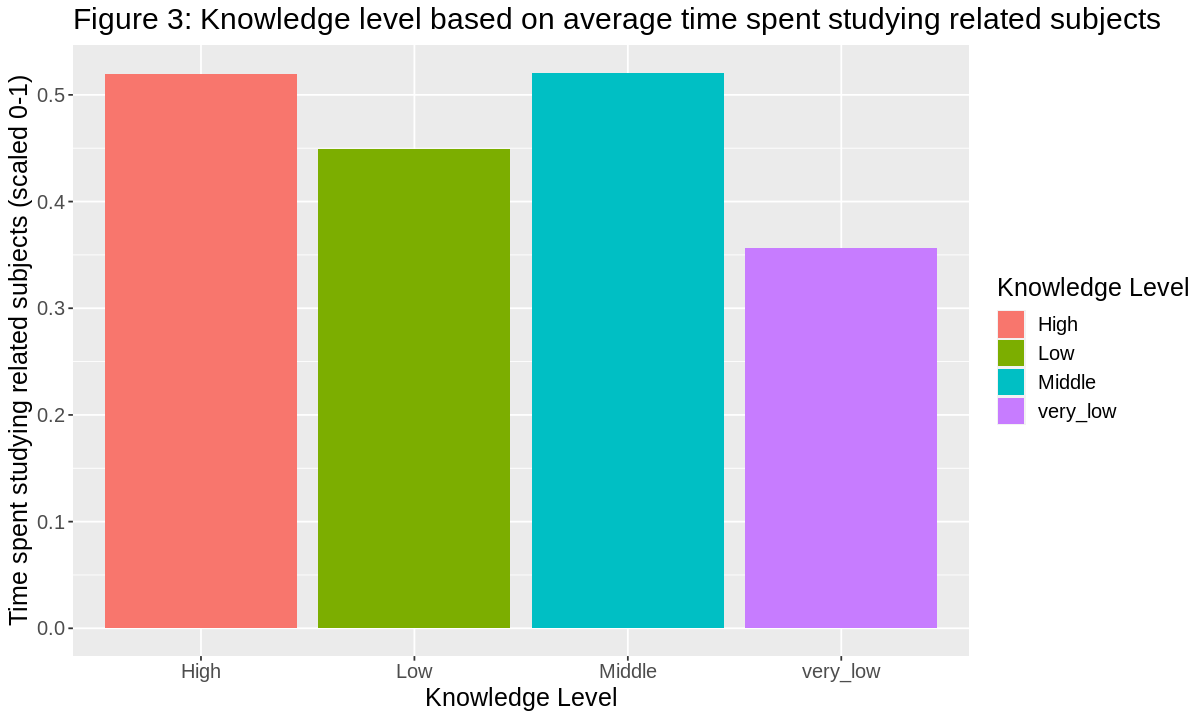

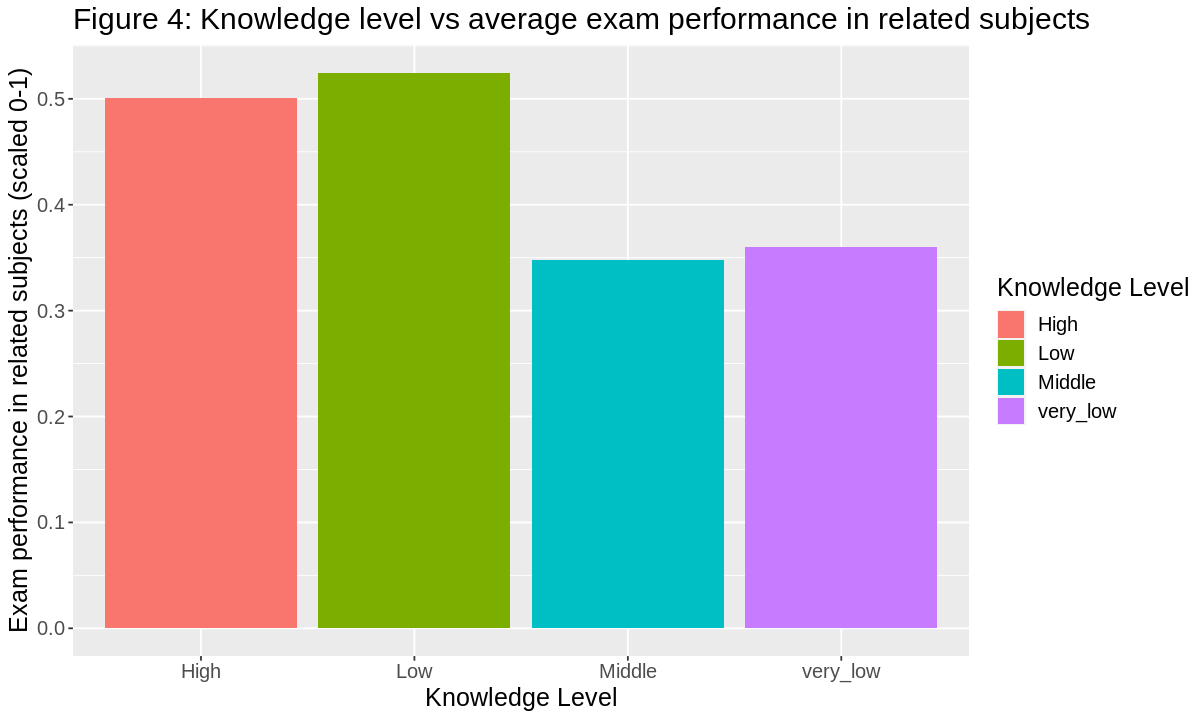

In [9]:
# Visualizing our training data into a scatter plot of student exam performance (%) vs the time the student spent
# studying the subject. The plot is coloured according to the student's knowledge level of Electrical DC Machines

options(repr.plot.width=10, repr.plot.height=6)

plot_exam_perf <- student_average |>
    ggplot(aes(x = knowledge_level, y = exam_performance_percentage, fill = knowledge_level)) +
    geom_bar(stat = "identity") +
    labs(x = "Knowledge Level",
         y = "Student exam performance (as a percentage)",
        fill = "Knowledge Level") +
    ggtitle("Figure 1: Knowledge level vs average student exam performance in goal subject") +
     theme(text = element_text(size = 15))
plot_exam_perf

plot_study_time <- student_average |>
    ggplot(aes(x = knowledge_level, y = study_time, fill = knowledge_level)) +
    geom_bar(stat = "identity") +
    labs(x = "Knowledge Level",
         y = "Time spent studying the subject(scaled 0-1)",
        fill = "Knowledge Level") +
    ggtitle("Figure 2: Knowledge level based on average time spent studying goal subject") +
    theme(text = element_text(size = 15))
plot_study_time

plot_rel_subject_time <- student_average |>
    ggplot(aes(x = knowledge_level, y = related_subject_time, fill = knowledge_level)) +
    geom_bar(stat = "identity") +
    labs(x = "Knowledge Level",
         y = "Time spent studying related subjects (scaled 0-1)",
        fill = "Knowledge Level") +
    ggtitle("Figure 3: Knowledge level based on average time spent studying related subjects") +
    theme(text = element_text(size = 15))
plot_rel_subject_time

plot_rel_exam_perf <- student_average |>
    ggplot(aes(x = knowledge_level, y = related_exam_performance, fill = knowledge_level)) +
    geom_bar(stat = "identity") +
    labs(x = "Knowledge Level",
         y = "Exam performance in related subjects (scaled 0-1)",
        fill = "Knowledge Level") +
    ggtitle("Figure 4: Knowledge level vs average exam performance in related subjects") +
    theme(text = element_text(size = 15))
plot_rel_exam_perf


In [10]:
# Summarizing only the variables we intend to use to predict the knowledge level. The predictive variables we are using are 
# study_time, and exam_performance_percentage. The categorical variable we would like to predict is knowledge_level

summarize_average <- student_average |>
    select(knowledge_level, study_time, exam_performance_percentage)
summarize_average

knowledge_level,study_time,exam_performance_percentage
<fct>,<dbl>,<dbl>
High,0.4130426,77.446809
Low,0.3255167,23.588333
Middle,0.4033846,53.676923
very_low,0.3156667,9.095238


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7155668,5,0.02829306,Preprocessor1_Model01
2,accuracy,multiclass,0.7155668,5,0.02829306,Preprocessor1_Model02
3,accuracy,multiclass,0.7931849,5,0.02772081,Preprocessor1_Model03
4,accuracy,multiclass,0.7931849,5,0.02772081,Preprocessor1_Model04
5,accuracy,multiclass,0.8142375,5,0.03523980,Preprocessor1_Model05
6,accuracy,multiclass,0.8142375,5,0.03523980,Preprocessor1_Model06
7,accuracy,multiclass,0.7987112,5,0.04219911,Preprocessor1_Model07
8,accuracy,multiclass,0.7934480,5,0.04199432,Preprocessor1_Model08
9,accuracy,multiclass,0.7673954,5,0.03062297,Preprocessor1_Model09


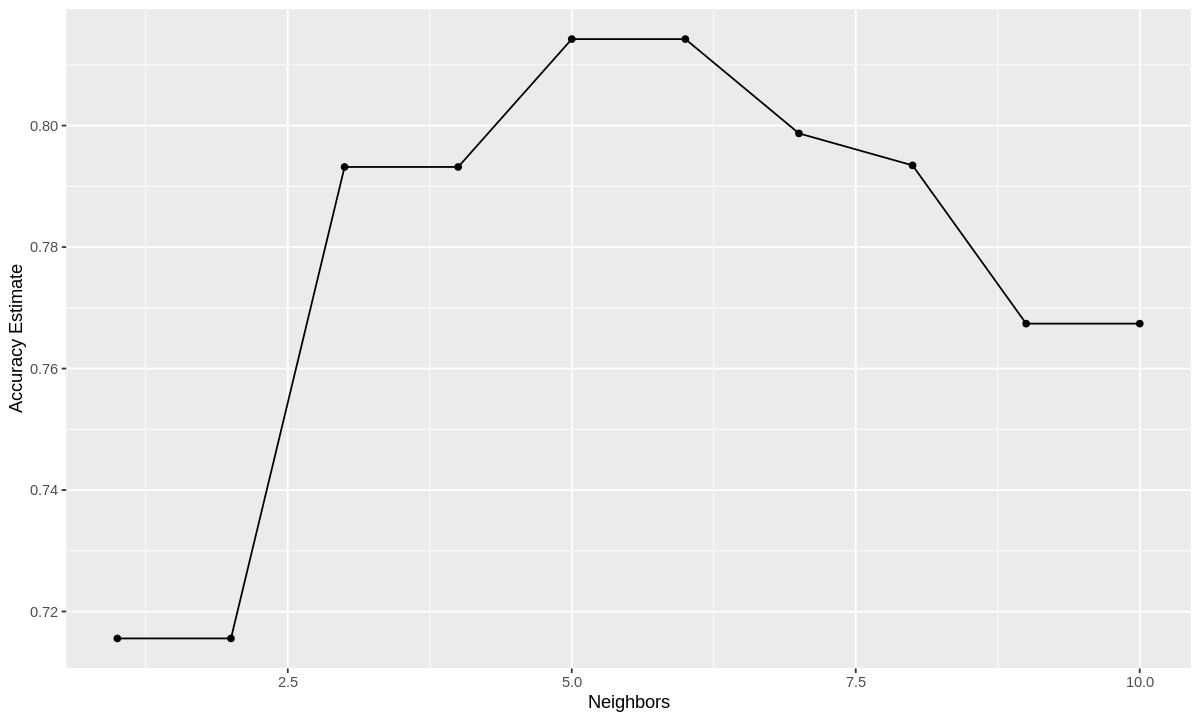

In [13]:
set.seed(7)

# Creating our recipe, model specification, and performing 5-fold cross-valdiation to choose the best K value for our model

student_recipe <- recipe(knowledge_level ~ study_time + exam_performance_percentage, data = student_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

student_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

student_vfold <- vfold_cv(student_train, v = 5, strata = knowledge_level)

student_results <- workflow() |>
    add_recipe(student_recipe) |>
    add_model(student_tune) |>
    tune_grid(resamples = student_vfold, grid = gridvals) |>
    collect_metrics()

accuracies <- student_results |> 
       filter(.metric == "accuracy")
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

In [19]:
# Performing our classification analysis on our testing data and obtaining the metrics of our analysis
set.seed(7)

student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification")

student_fit <- workflow() |>
    add_recipe(student_recipe) |>
    add_model(student_spec) |>
    fit(student_train)

student_predictions <- predict(student_fit, student_test) |>
    bind_cols(student_test) |>
    select(-related_subject_time, -related_exam_performance, -exam_performance) 

student_predictions_average <- student_predictions |>
    group_by(.pred_class, knowledge_level) |>
    summarize(avg_study_time = mean(study_time),
             avg_exam_performance = mean(exam_performance_percentage))
student_predictions_average

student_accrucy <- student_predictions|>
    metrics(truth = knowledge_level, estimate = .pred_class) |>
    filter(.metric == "accuracy")
student_accrucy

student_conf <- student_predictions |>
     conf_mat(truth = knowledge_level, estimate = .pred_class)
student_conf

`summarise()` has grouped output by '.pred_class'. You can override using the
`.groups` argument.


.pred_class,knowledge_level,avg_study_time,avg_exam_performance
<fct>,<fct>,<dbl>,<dbl>
High,High,0.3941818,82.000000
High,Middle,0.5600000,50.000000
Low,Low,0.3257000,26.400000
Low,Middle,0.2000000,25.000000
Low,very_low,0.2366667,9.000000
Middle,High,0.5630000,65.000000
Middle,Middle,0.3913333,57.571429
very_low,Low,0.2033333,9.666667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8


          Truth
Prediction High Low Middle very_low
  High       11   0      1        0
  Low         0  20      1        3
  Middle      5   0     21        0
  very_low    0   3      0        0

#### Methods

Using the columns UNS which we changed the name to "knowledge_level” as our categorical column we will use the variables STG, STR, LPR, and PEG which have been changed to  "study_time", "related_subject_time", "related_exam performance", and "exam_performance" in order to predict the knowledge level and determine the relationship between the 4 factors and whether they ultimately impact the knowledge level of a user. Column names have been changed to improve readability and the column SCG (degree of repetition number of users for goal object materials) has been removed due to unclear and non-relevant description.

In order to conduct our data analysis we tidied our dataset into clearly labeled columns, removed unnecessary factors, and using scatter-plots we plan to visualize the relationship of each factor to the knowledge level in order to determine trends and the strength of each relationship. 


#### Expected Outcomes and Significance

We expect to find students’ knowledge of Electrical DC Machines can be predicted based on their study time for goal object materials (STG), repetition number for goal object material (SCG), study time for related objects with goal objects (STR), exam performance for related objects with goal object (LPR), and exam performance for goal objects (PEG). Specifically, higher values of STG, SCG, STR, LPR and PEG are associated with high level students’ knowledge of Electrical DC Machines.  

These findings help us to know factors that influence the students’ knowledge levels in the context of Electrical DC Machines and help students make effective learning strategies. 

Furthermore, we can also find if there are some other factors that positively influence the level of students’ knowledge, as well as some study habits/factors that negatively influence the level of the students' knowledge.

#### Discussion

##### Our Findings



##### What we Expected



##### Impact of Findings


##### Future Questions

#### References